In [1]:
using Pkg
Pkg.activate("../")
#Pkg.instantiate()

  Activating project at `~/Documents/UCL/3x2_analytical`


In [2]:
using LinearAlgebra
using ForwardDiff
using Plots
using LimberJack
using CSV
using YAML
using NPZ
using DataFrames
using PythonCall
using Statistics
using Interpolations
using SparseArrays
sacc = pyimport("sacc");

# Judith's Chain

In [3]:
#using DelimitedFiles
#chain = readdlm("/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/cosmodc2_3x2pt_fourier_lcdm.txt");

In [4]:
#chain_vals = chain[200:end, :]
#param_names = chain[1, :];

#post = chain_vals[:, 32]
#index_of_min = argmax(post)
#row_with_min = chain_vals[index_of_min, :]
#Wm = row_with_min[1]+row_with_min[2]
#Wb = row_with_min[2]
#h0 = row_with_min[5]
#ns = row_with_min[3]
#s8 = row_with_min[29]
#best_params = [Wm, Wb, h0, s8, ns]
#print(best_params)

#nuisances = Dict(
#    "lens_0_b" => row_with_min[13],
#    "lens_1_b" => row_with_min[14],
#    "lens_2_b" => row_with_min[15],
#    "lens_3_b" => row_with_min[16],
#    "lens_4_b" => row_with_min[17],
#    "source_0_m" => row_with_min[8],
#    "source_1_m" => row_with_min[9],
#    "source_2_m" => row_with_min[10],
#    "source_3_m" => row_with_min[11],
#    "source_4_m" => row_with_min[12])

In [5]:
function make_Cmod(m, model)
    T = ForwardDiff.jacobian(model, zeros(m))
    return T * T'
end

make_Cmod (generic function with 1 method)

## Data

In [6]:
method = "sompz" # "bpz" or "sompz"
sacc_path = "../data/CosmoDC2/summary_statistics_fourier_tjpcov.sacc"
yaml_path = "../data/CosmoDC2/gcgc.yml"
nz_path = string("../data/CosmoDC2/image_dz_", method, "_priors/")

sacc_file = sacc.Sacc().load_fits(sacc_path)
yaml_file = YAML.load_file(yaml_path)

nz_lens_0 = npzread(string(nz_path, "dz_lens_0.npz"))
nz_lens_1 = npzread(string(nz_path, "dz_lens_1.npz"))
nz_lens_2 = npzread(string(nz_path, "dz_lens_2.npz"))
nz_lens_3 = npzread(string(nz_path, "dz_lens_3.npz"))
nz_lens_4 = npzread(string(nz_path, "dz_lens_4.npz"))

meta, files = make_data(sacc_file, yaml_file;
    nz_lens_0=nz_lens_0,
    nz_lens_1=nz_lens_1,
    nz_lens_2=nz_lens_2,
    nz_lens_3=nz_lens_3,
    nz_lens_4=nz_lens_4)

meta.types = [ 
    "galaxy_density",
    "galaxy_density",
    "galaxy_density",
    "galaxy_density",
    "galaxy_density"];

lens_0 lens_0 6
lens_1 lens_1 7
lens_2 lens_2 8
lens_3 lens_3 9
lens_4 lens_4 9
using custom nz for nz_lens_0
using custom nz for nz_lens_1
using custom nz for nz_lens_2
using custom nz for nz_lens_3
using custom nz for nz_lens_4


## dZ

In [7]:
nz_path = string("../data/CosmoDC2/image_dz_", method, "_priors/")
nz_lens_0 = npzread(string(nz_path, "dz_lens_0.npz"))
nz_lens_1 = npzread(string(nz_path, "dz_lens_1.npz"))
nz_lens_2 = npzread(string(nz_path, "dz_lens_2.npz"))
nz_lens_3 = npzread(string(nz_path, "dz_lens_3.npz"))
nz_lens_4 = npzread(string(nz_path, "dz_lens_4.npz"))
zs_k0, nz_k0 = nz_lens_0["z"], nz_lens_0["dndz"]
zs_k1, nz_k1 = nz_lens_1["z"], nz_lens_1["dndz"]
zs_k2, nz_k2 = nz_lens_2["z"], nz_lens_2["dndz"]
zs_k3, nz_k3 = nz_lens_3["z"], nz_lens_3["dndz"]
zs_k4, nz_k4 = nz_lens_4["z"], nz_lens_4["dndz"]
chol_lens_0 = nz_lens_0["chol"]
chol_lens_1 = nz_lens_1["chol"]
chol_lens_2 = nz_lens_2["chol"]
chol_lens_3 = nz_lens_3["chol"]
chol_lens_4 = nz_lens_4["chol"];

In [8]:
function model_dz(alphas; 
    Ωm=0.27347, σ8=0.779007, Ωb=0.04217, h=0.71899, ns=0.99651,
    lens_0_b=0.879118, 
    lens_1_b=1.05894, 
    lens_2_b=1.22145, 
    lens_3_b=1.35065, 
    lens_4_b=1.58909,
    meta=meta, files=files)

    dz_lens_0 = chol_lens_0 * alphas[1]
    dz_lens_1 = chol_lens_1 * alphas[2]
    dz_lens_2 = chol_lens_2 * alphas[3]
    dz_lens_3 = chol_lens_3 * alphas[4]
    dz_lens_4 = chol_lens_4 * alphas[5]

    lens_0_zs   = @.(zs_k0 + dz_lens_0)
    lens_1_zs   = @.(zs_k1 + dz_lens_1)
    lens_2_zs   = @.(zs_k2 + dz_lens_2)
    lens_3_zs   = @.(zs_k3 + dz_lens_3)
    lens_4_zs   = @.(zs_k4 + dz_lens_4)

    nuisances = Dict(
    "lens_0_b"    => lens_0_b,
    "lens_1_b"    => lens_1_b,
    "lens_2_b"    => lens_2_b,
    "lens_3_b"    => lens_3_b,
    "lens_4_b"    => lens_4_b,
    "lens_0_zs"   => lens_0_zs,
    "lens_1_zs"   => lens_1_zs,
    "lens_2_zs"   => lens_2_zs,
    "lens_3_zs"   => lens_3_zs,
    "lens_4_zs"   => lens_4_zs)
        
    cosmo = Cosmology(Ωm=Ωm, Ωb=Ωb, h=h, ns=ns, σ8=σ8,
        tk_mode=:EisHu,
        pk_mode=:Halofit)

    cosmo.settings.cosmo_type = eltype(valtype(alphas))
    return Theory(cosmo, meta, files; Nuisances=nuisances)
end;

In [9]:
Cmod_dz = make_Cmod(10, model_dz);

## wzdz

In [10]:
nz_path = string("../data/CosmoDC2/image_wzdz_", method, "_priors/")
nz_lens_0 = npzread(string(nz_path, "wzdz_lens_0.npz"))
nz_lens_1 = npzread(string(nz_path, "wzdz_lens_1.npz"))
nz_lens_2 = npzread(string(nz_path, "wzdz_lens_2.npz"))
nz_lens_3 = npzread(string(nz_path, "wzdz_lens_3.npz"))
nz_lens_4 = npzread(string(nz_path, "wzdz_lens_4.npz"))

zs_k0, nz_k0 = nz_lens_0["z"], nz_lens_0["dndz"]
zs_k1, nz_k1 = nz_lens_1["z"], nz_lens_1["dndz"]
zs_k2, nz_k2 = nz_lens_2["z"], nz_lens_2["dndz"]
zs_k3, nz_k3 = nz_lens_3["z"], nz_lens_3["dndz"]
zs_k4, nz_k4 = nz_lens_4["z"], nz_lens_4["dndz"]

mu_k0 = sum(zs_k0 .* nz_k0) / sum(nz_k0)
mu_k1 = sum(zs_k1 .* nz_k1) / sum(nz_k1)
mu_k2 = sum(zs_k2 .* nz_k2) / sum(nz_k2)
mu_k3 = sum(zs_k3 .* nz_k3) / sum(nz_k3)
mu_k4 = sum(zs_k4 .* nz_k4) / sum(nz_k4)

chol_lens_0 = nz_lens_0["chol"]
chol_lens_1 = nz_lens_1["chol"]
chol_lens_2 = nz_lens_2["chol"]
chol_lens_3 = nz_lens_3["chol"]
chol_lens_4 = nz_lens_4["chol"];

In [11]:
function model_wzdz(alphas; 
    Ωm=0.27347, σ8=0.779007, Ωb=0.04217, h=0.71899, ns=0.99651,
    lens_0_b=0.879118, 
    lens_1_b=1.05894, 
    lens_2_b=1.22145, 
    lens_3_b=1.35065, 
    lens_4_b=1.58909,
    meta=meta, files=files)

    snw_lens_0 = chol_lens_0 * alphas[1:2]
    dz_lens_0 = snw_lens_0[1]
    wz_lens_0 = 1 + snw_lens_0[2]

    snw_lens_1 = chol_lens_1 * alphas[3:4]
    dz_lens_1 = snw_lens_1[1]
    wz_lens_1 = 1 + snw_lens_1[2]

    snw_lens_2 = chol_lens_2 * alphas[5:6]
    dz_lens_2 = snw_lens_2[1]
    wz_lens_2 = 1 + snw_lens_2[2]

    snw_lens_3 = chol_lens_3 * alphas[7:8]
    dz_lens_3 = snw_lens_3[1]
    wz_lens_3 = 1 + snw_lens_3[2]

    snw_lens_4 = chol_lens_4 * alphas[9:10]
    dz_lens_4 = snw_lens_4[1]
    wz_lens_4 = 1 + snw_lens_4[2]

    lens_0_zs   = @.((zs_k0-mu_k0)/wz_lens_0 + dz_lens_0/wz_lens_0 + mu_k0)
    lens_1_zs   = @.((zs_k1-mu_k1)/wz_lens_1 + dz_lens_1/wz_lens_1 + mu_k1)
    lens_2_zs   = @.((zs_k2-mu_k2)/wz_lens_2 + dz_lens_2/wz_lens_2 + mu_k2)
    lens_3_zs   = @.((zs_k3-mu_k3)/wz_lens_3 + dz_lens_3/wz_lens_3 + mu_k3)
    lens_4_zs   = @.((zs_k4-mu_k4)/wz_lens_4 + dz_lens_4/wz_lens_4 + mu_k4)

    nuisances = Dict(
        "lens_0_b"    => lens_0_b,
        "lens_1_b"    => lens_1_b,
        "lens_2_b"    => lens_2_b,
        "lens_3_b"    => lens_3_b,
        "lens_4_b"    => lens_4_b,
        "lens_0_zs"   => lens_0_zs,
        "lens_1_zs"   => lens_1_zs,
        "lens_2_zs"   => lens_2_zs,
        "lens_3_zs"   => lens_3_zs,
        "lens_4_zs"   => lens_4_zs)
        
    cosmo = Cosmology(Ωm=Ωm, Ωb=Ωb, h=h, ns=ns, σ8=σ8,
        tk_mode=:EisHu,
        pk_mode=:Halofit)

    cosmo.settings.cosmo_type = eltype(valtype(alphas))
    return Theory(cosmo, meta, files; Nuisances=nuisances)
end;

In [12]:
Cmod_wzdz = make_Cmod(20, model_wzdz);

## PCA

In [13]:
nz_path = string("../data/CosmoDC2/image_PCA_", method, "_priors/")
nz_lens_0 = npzread(string(nz_path, "PCA_lens_0.npz"))
nz_lens_1 = npzread(string(nz_path, "PCA_lens_1.npz"))
nz_lens_2 = npzread(string(nz_path, "PCA_lens_2.npz"))
nz_lens_3 = npzread(string(nz_path, "PCA_lens_3.npz"))
nz_lens_4 = npzread(string(nz_path, "PCA_lens_4.npz"))
zs_k0, nz_k0 = nz_lens_0["z"], nz_lens_0["dndz"]
zs_k1, nz_k1 = nz_lens_1["z"], nz_lens_1["dndz"]
zs_k2, nz_k2 = nz_lens_2["z"], nz_lens_2["dndz"]
zs_k3, nz_k3 = nz_lens_3["z"], nz_lens_3["dndz"]
zs_k4, nz_k4 = nz_lens_4["z"], nz_lens_4["dndz"]
W_lens_0 = nz_lens_0["W"]
W_lens_1 = nz_lens_1["W"]
W_lens_2 = nz_lens_2["W"]
W_lens_3 = nz_lens_3["W"]
W_lens_4 = nz_lens_4["W"];

In [14]:
function model_pca(alphas; 
    Ωm=0.27347, σ8=0.779007, Ωb=0.04217, h=0.71899, ns=0.99651,
    lens_0_b=0.879118, 
    lens_1_b=1.05894, 
    lens_2_b=1.22145, 
    lens_3_b=1.35065, 
    lens_4_b=1.58909,
    meta=meta, files=files)

    nz_lens_0 = nz_k0 + W_lens_0 * alphas[1:5]
    nz_lens_1 = nz_k1 + W_lens_1 * alphas[6:10]
    nz_lens_2 = nz_k2 + W_lens_2 * alphas[11:15]
    nz_lens_3 = nz_k3 + W_lens_3 * alphas[16:20]
    nz_lens_4 = nz_k4 + W_lens_4 * alphas[21:25]

    nuisances = Dict(
        "lens_0_b"    => lens_0_b,
        "lens_1_b"    => lens_1_b,
        "lens_2_b"    => lens_2_b,
        "lens_3_b"    => lens_3_b,
        "lens_4_b"    => lens_4_b,
        "lens_0_nz"   => nz_lens_0,
        "lens_1_nz"   => nz_lens_1,
        "lens_2_nz"   => nz_lens_2,
        "lens_3_nz"   => nz_lens_3,
        "lens_4_nz"   => nz_lens_4)
        
    cosmo = Cosmology(Ωm=Ωm, Ωb=Ωb, h=h, ns=ns, σ8=σ8,
        tk_mode=:EisHu,
        pk_mode=:Halofit)

    cosmo.settings.cosmo_type = eltype(valtype(alphas))
    return Theory(cosmo, meta, files; Nuisances=nuisances)
end;

In [15]:
Cmod_pca = make_Cmod(50, model_pca);

## GP

In [16]:
nz_path = string("../data/CosmoDC2/image_gp_", method, "_priors/")

nz_lens_0 = npzread(string(nz_path, "gp_lens_0.npz"))
nz_lens_1 = npzread(string(nz_path, "gp_lens_1.npz"))
nz_lens_2 = npzread(string(nz_path, "gp_lens_2.npz"))
nz_lens_3 = npzread(string(nz_path, "gp_lens_3.npz"))
nz_lens_4 = npzread(string(nz_path, "gp_lens_4.npz"))
zs_k0, nz_k0 = nz_lens_0["z"], nz_lens_0["dndz"]
zs_k1, nz_k1 = nz_lens_1["z"], nz_lens_1["dndz"]
zs_k2, nz_k2 = nz_lens_2["z"], nz_lens_2["dndz"]
zs_k3, nz_k3 = nz_lens_3["z"], nz_lens_3["dndz"]
zs_k4, nz_k4 = nz_lens_4["z"], nz_lens_4["dndz"]
W_lens_0 = nz_lens_0["W"]
W_lens_1 = nz_lens_1["W"]
W_lens_2 = nz_lens_2["W"]
W_lens_3 = nz_lens_3["W"]
W_lens_4 = nz_lens_4["W"];


In [17]:
function nz_itp(q, nq, z)
    dq = mean(q[2:end] - q[1:end-1])
    q_range = q[1]:dq:q[end]
    nz_int = cubic_spline_interpolation(q_range, nq;
        extrapolation_bc=Line())
    return nz_int(z)
end

function model_gp(alphas; 
    Ωm=0.27347, σ8=0.779007, Ωb=0.04217, h=0.71899, ns=0.99651,
    lens_0_b=0.879118, 
    lens_1_b=1.05894, 
    lens_2_b=1.22145, 
    lens_3_b=1.35065, 
    lens_4_b=1.58909,
    meta=meta, files=files)

    nz_lens_0 = nz_k0 + W_lens_0 * alphas[1:5]
    nz_lens_1 = nz_k1 + W_lens_1 * alphas[6:10]
    nz_lens_2 = nz_k2 + W_lens_2 * alphas[11:15]
    nz_lens_3 = nz_k3 + W_lens_3 * alphas[16:20]
    nz_lens_4 = nz_k4 + W_lens_4 * alphas[21:25]

    nuisances = Dict(
        "lens_0_b"    => lens_0_b,
        "lens_1_b"    => lens_1_b,
        "lens_2_b"    => lens_2_b,
        "lens_3_b"    => lens_3_b,
        "lens_4_b"    => lens_4_b,
        "lens_0_nz"   => nz_lens_0,
        "lens_1_nz"   => nz_lens_1,
        "lens_2_nz"   => nz_lens_2,
        "lens_3_nz"   => nz_lens_3,
        "lens_4_nz"   => nz_lens_4)
        
    cosmo = Cosmology(Ωm=Ωm, Ωb=Ωb, h=h, ns=ns, σ8=σ8,
        tk_mode=:EisHu,
        pk_mode=:Halofit)

    cosmo.settings.cosmo_type = eltype(valtype(alphas))
    return Theory(cosmo, meta, files; Nuisances=nuisances)
end;

In [18]:
Cmod_gp = make_Cmod(50, model_gp);

# Comp

In [19]:
print(log10.(diag(Cmod_wzdz) ./ diag(meta.cov)))

[-4.629218248413557, -4.199843772196671, -3.776012924973161, -3.423640193890494, -3.087550266437952, -2.7992101738402715, -4.469265110314675, -3.986922489043431, -3.6076172971788023, -3.247663383547557, -2.7962111141589694, -2.56005730554303, -2.195713214905693, -4.542110737587637, -3.992998325421771, -3.6717296192406645, -3.327868707885658, -2.9454372490108867, -2.625636628972352, -2.339962140397333, -2.0048237295405307, -4.615304146410716, -4.016415314954935, -3.7030652243572533, -3.288443264524764, -2.895173029343803, -2.613720658095165, -2.1884733948329487, -1.968329007636488, -1.6284419043659044, -3.9443512889827494, -3.530065528534418, -3.0744427811015256, -2.7537722795298634, -2.261613489049407, -1.9699805831294466, -1.590039807952222, -1.1671406791500907, -0.8934725535867967]

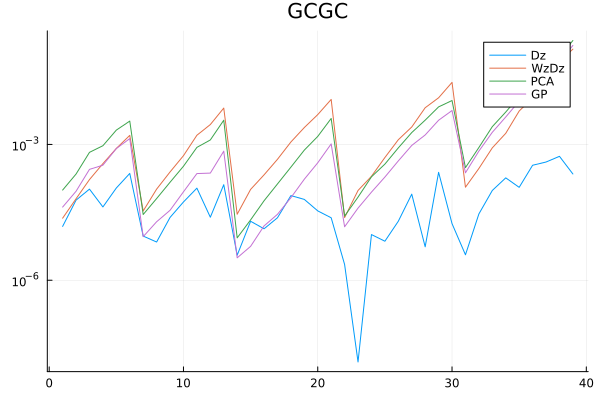

In [20]:
plot(diag(Cmod_dz) ./ diag(meta.cov), label="Dz", yscale=:log10)
plot!(diag(Cmod_wzdz) ./ diag(meta.cov), label="WzDz", yscale=:log10)
plot!(diag(Cmod_pca) ./ diag(meta.cov), label="PCA", yscale=:log10)
plot!(diag(Cmod_gp) ./ diag(meta.cov), label="GP", yscale=:log10, title="GCGC")

## Save

In [21]:
using NPZ
npzwrite(string("../covs/COSMODC2/", method, "_gcgc_tpts_covs.npz"),
        Dict(
        "cov"     => meta.cov,
        "TT_dz"   => Symmetric(meta.cov + Cmod_dz),
        "TT_wzdz" => Symmetric(meta.cov + Cmod_wzdz),
        "TT_pca"  => Symmetric(meta.cov + Cmod_pca),
        "TT_gp"   => Symmetric(meta.cov + Cmod_gp)))